# `SciPy`, `iminuit` and `uncertainties` - Or "How to extract physical quantities from data"?

We want to extract paramters from our data (or simulation). 
Therefore, we perform fits of models to the data and need to do proper error propagation.

**Important:** This course **will not** be an introduction to statistics, neither we will do full coverage of the tools.

If you do need a theory introduction and are unfamiliar with the statistical background of this course, 
consider the following ["Foundations to Statistics" lectures 1-4](https://indico.cern.ch/event/1347523/timetable/#20-foundations-of-statistics-1) by Glen Cowan which is part of the CERN Summer Student Programme.

## Documentation

Please refer to the documentations of the tools.  

### SciPy
The docs are here: [docs.scipy.org/doc/scipy/](https://docs.scipy.org/doc/scipy/)

Note that the `scipy` package is quite heavy.
The [user guide](https://docs.scipy.org/doc/scipy/tutorial/index.html#user-guide) contains currently 16 subpackages. These include tools on Fourier Transformation, integration, interpolation, linear algebra.
Today we will focus on [scipy.optimize](https://docs.scipy.org/doc/scipy/tutorial/optimize.html) package.

### iminuit
The docs are here: [https://scikit-hep.org/iminuit/](https://scikit-hep.org/iminuit/)

`iminuit` provides various tutorials, it is strongly recommended to have a look at the ["basics" tutorial](https://scikit-hep.org/iminuit/notebooks/basic.html).
But also other tutorials give detailed information about various special applications of the iminuit library. Also [studies](https://scikit-hep.org/iminuit/studies.html) on performance in terms of speed, and comparison with other tools like SciPy optimizers and also in comparison with ROOT's RooFit (which you will learn about in another course). 

### uncertainties
The docs are here: [uncertainties.readthedocs.io/](https://uncertainties.readthedocs.io/) 

The [user guide](https://uncertainties.readthedocs.io/en/latest/user_guide.html) of the `uncertainties` package provides also information on many topics that we will not cover in todays introduction session (e.g. treatment of systematic uncertainties).   

## Introduction

What we will do is an introduction to the three python modules, `scipy` `iminuit` and `uncertainties` in the context of fits and error propagation.  
As usual we will have to use on top of this `numpy` and `matplotlib`.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import uncertainties as unc
from iminuit import Minuit, cost
from numba_stats import truncnorm, truncexpon

## Least Square Fits

Let's start simple with  a linear fit.

In [2]:
def line(x, a, b):
    return a * x + b

For our test, we need to generate some data points.  
Always use the `numpy` "random number generator" (`rng`) if possible.

In [3]:
rng = np.random.default_rng(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1
data_y = rng.normal(line(data_x, 1, 2), data_yerr)

Now we plot our data points.

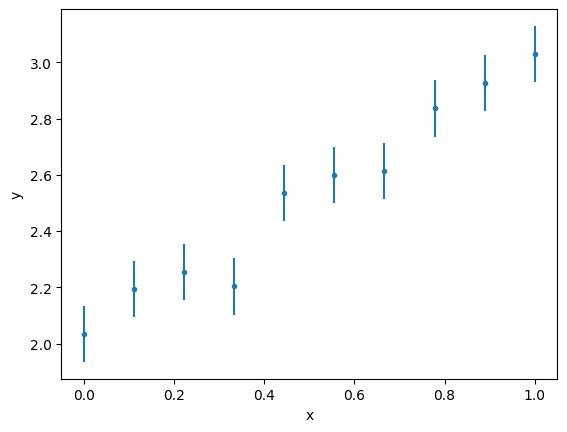

In [4]:
_, ax = plt.subplots()
ax.errorbar(data_x, data_y, yerr=data_yerr, fmt=".")
ax.set(xlabel="x", ylabel="y");

To perform a fit you need a function that you want to minimize, your so called cost function.

One common example is a $\chi^{2}$ function.

This is defined as 
$$
\chi^{2} = \sum_{i} \left(\frac{y_i - f(x_i)}{\sigma_i}\right)^{2} \, .
$$

### Least-Squares Fit in `iminuit`

In `iminuit` we find this implemented as [`iminuit.cost.LeastSquares`](https://scikit-hep.org/iminuit/reference.html#iminuit.cost.LeastSquares).  
We have to provide our $x_i$ called `x`, our $y_i$ called `y`, our $\sigma_i$ called `yerror` and our function $f$ called `model`. 

In [5]:
least_squares = cost.LeastSquares(x=data_x, y=data_y, yerror=data_yerr, model=line)

Now we want to minimize this `least_squares` object including the above inputs in `iminuit`.  
We can also provide start parameters to the `Minuit` minimizer object.  
It minimizes for us the function ([`Minuit.migrad()`](https://scikit-hep.org/iminuit/reference.html#iminuit.Minuit.migrad)) and computes the corresponding errors([`Minuit.hesse()`](https://scikit-hep.org/iminuit/reference.html#iminuit.Minuit.hesse)).

In [6]:
m = Minuit(fcn=least_squares, a=0, b=0)

m.migrad() # finds minimum of least_squares function
m.hesse() # computes uncertainties, symmetric

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.959 (χ²/ndof = 0.5)      │              Nfcn = 42               │
│ EDM = 2.53e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    1.0    │    0.1    │            │            │         │         │       │
│ 1 │ b    │   2.02    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00982 -0.0049 │
│ b │ -0.0049 0.00345 │
└───┴─────────────────┘

We can get the parameters by calling its attributes with `Minuit.values` and `Minuit.errors`.

In [7]:
m.values, m.errors, m.covariance

(<ValueView a=0.9968944564252313 b=2.024043595596149>,
 <ErrorView a=0.09908677656069555 b=0.05877539671220773>,
 ┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00982 -0.0049 │
│ b │ -0.0049 0.00345 │
└───┴─────────────────┘)

### Least-Squares Fits in SciPy

With `SciPy.curve_fit` we can do the same thing.  
We have to provide our function $f$ called `f`, $x_i$ called `x_data`, our $y_i$ called `y_data`, our start parameters called `p0`, our $\sigma_i$ called `sigma` and we need to tell it that our `sigma` values are actually the uncertainties of our `y_values` by setting `absolute_sigma=True`. 

It returns us the optimal parameters, let's call them `param_opt` and the covarinance matrix, we call it `param_cov`.

From our statistics lectures we know that we can get the uncertainty from the square root of the diagonal elements of the covariance matrix,  
so we can call `np.sqrt(np.diag(param_cov))`, to get our uncertainties.

In [8]:
param_opt, param_cov = opt.curve_fit(f=line, 
                           xdata=data_x, 
                           ydata=data_y, 
                           p0=[0, 0],
                           sigma=data_yerr, 
                           absolute_sigma=True
                          )
param_err = np.sqrt(np.diag(param_cov))  # Standard deviation errors on parameters

param_opt, param_err, param_cov

(array([0.99689445, 2.0240436 ]),
 array([0.09908674, 0.05877538]),
 array([[ 0.00981818, -0.00490909],
        [-0.00490909,  0.00345455]]))

### `Uncertainties`: Example

Using the `uncertainty` package, and combining them in floats with uncertainties (`ufloats`), we get the following:

In [9]:
def get_unc(values, errs):
    return [unc.ufloat(value, err) for value, err in zip(values, errs)]

uparams_minuit = get_unc(m.values, m.errors)

uparams_scipy = get_unc(param_opt, param_err)

So let's compare them.

In [10]:
def print_param(name, uparams_minuit, uparams_scipy):
    print(f"{name}: \t Minuit: {uparams_minuit} \t SciPy: {uparams_scipy}")


print_param("a", uparams_minuit[0], uparams_scipy[0])
print_param("b", uparams_minuit[1], uparams_scipy[1])

a: 	 Minuit: 1.00+/-0.10 	 SciPy: 1.00+/-0.10
b: 	 Minuit: 2.02+/-0.06 	 SciPy: 2.02+/-0.06


Why is the uncertainty package nice (the formatting is cool already, but what else)?

Because it does error propagation for us.
Imagine we want to use the fit now to extrapolate to some new value at the value `x_extra=1.2`.

In [11]:
x_extra = 1.2
y_extra = line(x_extra, uparams_minuit[0], uparams_minuit[1])
y_extra

3.2203169433064267+/-0.13263762601580992

Great, we get the error computation for free.

Now let's make a nice plot to see the data, the fit, and our extrapolated value. 

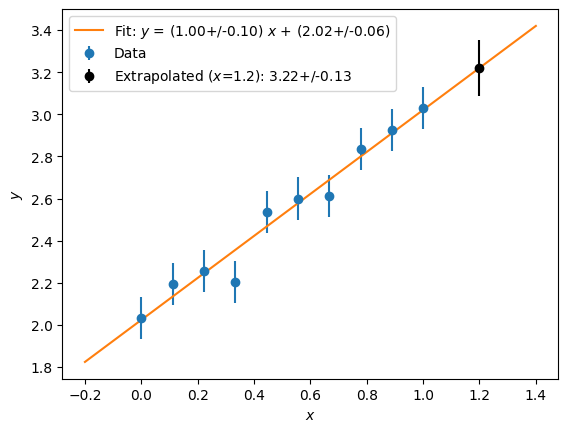

In [12]:
# Plot the data and the fit
x_fit = np.linspace(-0.2, 1.4, 100)
y_fit = line(x_fit, uparams_minuit[0].nominal_value, uparams_minuit[1].nominal_value)

_, ax = plt.subplots()
ax.errorbar(data_x, data_y, yerr=data_yerr, fmt='o', label='Data')
ax.plot(x_fit, y_fit, label=f'Fit: $y$ = ({uparams_minuit[0]}) $x$ + ({uparams_minuit[1]})')
ax.errorbar(x_extra, y_extra.nominal_value, yerr=y_extra.std_dev, fmt="ok", label=f'Extrapolated ($x$={x_extra}): {y_extra}')
ax.set(xlabel="$x$", ylabel="$y$")
ax.legend();

Wonderful!  

But wait... the uncertainty seems to be unexpected large, no?

We provided our uncertainty parameters `uparams_minuit` and `uparams_scipy` only with values and uncertainties, not with correlations.  
What was `m.covariance` and `param_cov`?

In [13]:
m.covariance, param_cov

(┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00982 -0.0049 │
│ b │ -0.0049 0.00345 │
└───┴─────────────────┘,
 array([[ 0.00981818, -0.00490909],
        [-0.00490909,  0.00345455]]))

Aha! We forgot that these values are correlated.

Of course correct error propagation is for two variables
$$
\sigma_y = \sqrt{ \left(\frac{\partial f}{\partial a} \sigma_{a}\right)^{2} + \left(\frac{\partial f}{\partial b} \sigma_{b}\right)^{2} + 2 \cdot\frac{\partial y}{\partial a} \frac{\partial y}{\partial b} \mathrm{Cov}(a,b)}
$$
so for our linear function this leads to
$$
\sigma_y = \sqrt{(x \cdot \sigma_a)^{2} + (\sigma_b)^{2} + 2 \cdot x \cdot \mathrm{Cov}(a,b)} \, .
$$

If we compute this by hand we see, that this is not what our function returned before.

In [14]:
perr = m.errors
cov_ab = m.covariance[0, 1]  # Covariance between a and b
sigma_y = np.sqrt((x_extra * perr[0])**2 + (perr[1])**2 + 2 * x_extra * cov_ab)
sigma_y, y_extra.std_dev

(0.07622934359327144, 0.13263762601580992)

But can we do something about this? Of course!  
Uncertainties comes with a [function for correlated variables](https://uncertainties.readthedocs.io/en/latest/user_guide.html#correlated-variables) called `uncertainties.correlated_values`.  
Let's try this.

**Notice**: In this perspective `uncertainties` becomes a bit ugly, especially because it is kind of unpredictable in the way it handles things.

In [15]:
uparams_minuit_not_correlated = get_unc(m.values, m.errors)
uparams_minuit_correlated = unc.correlated_values(m.values, m.covariance)
uparams_minuit_not_correlated, uparams_minuit_correlated

([0.9968944564252313+/-0.09908677656069555,
  2.024043595596149+/-0.05877539671220773],
 (0.9968944564252313+/-0.09908677656069553,
  2.024043595596149+/-0.05877539671220773))

Okay, so we have two param objects, in which both values look exactly the same.  
But let's get their covariance matrix.

In [16]:
unc.covariance_matrix(uparams_minuit_not_correlated)

[[0.009818189289189205, 0.0], [0.0, 0.0034545472586773995]]

In [17]:
unc.covariance_matrix(uparams_minuit_correlated)

[[0.009818189289189202, -0.004909094587687007],
 [-0.004909094587687007, 0.0034545472586773995]]

Now we see a difference!  
One of them has non-zero off-diagonal elements, while the other has zeros instead.

To me this is a super odd way of giving these objects this information.  
One has to take very good care about variables which are correlated vs. variables which are uncorrelated.

But anyways, let's test it.
One time without correlation, one time with correlation.

In [18]:
y_extra = line(x_extra, uparams_minuit_not_correlated[0], uparams_minuit_not_correlated[1])
y_extra

3.2203169433064267+/-0.13263762601580992

In [19]:
y_extra = line(x_extra, uparams_minuit_correlated[0], uparams_minuit_correlated[1])
y_extra

3.2203169433064267+/-0.07622934359327142

So we see, it corresponds to our hand-computed `sigma_y` variable (up to the last digit). Great!

In [20]:
sigma_y, y_extra.std_dev

(0.07622934359327144, 0.07622934359327142)

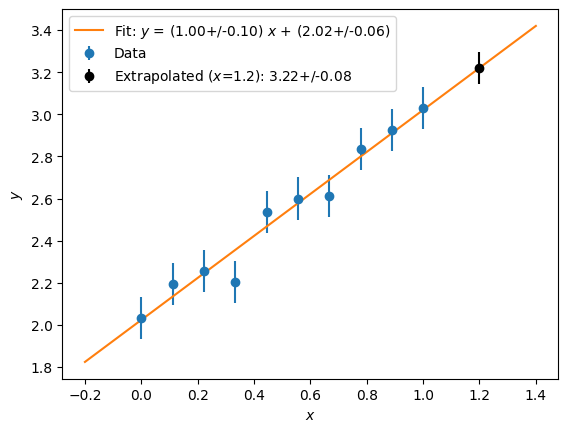

In [21]:
x_extra = 1.2
y_extra = line(x_extra, uparams_minuit_correlated[0], uparams_minuit_correlated[1])

# Plot the data and the fit
x_fit = np.linspace(-0.2, 1.4, 100)
y_fit = line(x_fit, uparams_minuit_correlated[0].nominal_value, uparams_minuit_correlated[1].nominal_value)

_, ax = plt.subplots()
ax.errorbar(data_x, data_y, yerr=data_yerr, fmt='o', label='Data')
ax.plot(x_fit, y_fit, label=f'Fit: $y$ = ({uparams_minuit_correlated[0]}) $x$ + ({uparams_minuit_correlated[1]})')
ax.errorbar(x_extra, y_extra.nominal_value, yerr=y_extra.std_dev, fmt="ok", label=f'Extrapolated ($x$={x_extra}): {y_extra}')
ax.set(xlabel="$x$", ylabel="$y$")
ax.legend();

## Maximum-Likelihood Fits

Way more often than Least Square in High Energy Physics (HEP) we do maximum-likelihood fits.  
There is a [nice introduction in iminuit on this topic](https://scikit-hep.org/iminuit/notebooks/cost_functions.html#Maximum-likelihood-fits).

Again we don't want to do the statistics course, but instead focus on the tool.

But the good thing is, we know the tool already!

Let's start by generate some data. We want to combine some normal distribution with an exponential.  
You ever saw the Higgs discovery?

![Higgs](https://cds.cern.ch/record/2230893/files/HiggsGammaGamma.gif?subformat=icon-640 "Higgs")

Okay, we will do it a bit more simple.

In [22]:
signal_window = (100, 160)

signal = rng.normal(125, 1.5, size=700)
signal = signal[(signal_window[0] < signal) & (signal < signal_window[1])]
background = rng.exponential(scale=40, size=600_000)
background = background[(signal_window[0] < background) & (background < signal_window[1])]
data = np.append(signal, background)

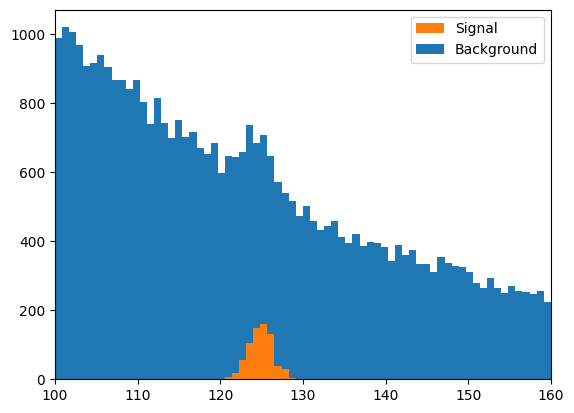

In [23]:
plt.hist((signal, background), bins=70, color=("C1", "C0"), stacked=True, label=("Signal", "Background"))
plt.xlim(signal_window)
plt.legend();

So our data points look like this.

In [24]:
counts, bins = np.histogram(data, bins=70)
centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]

_, ax = plt.subplots()
ax.errorbar(centers, counts, np.sqrt(counts), fmt="ok", label="Data")
ax.set_xlabel("$m$")
ax.set_ylabel("Counts")
plt.legend();

As I said, we already know what to do.  
Instead of our linear model we just have to write down the corresponding probablity density function.

We use here for convenience some pre-defined function from the tool `numba_stats`.  
This works especially well with `iminuit` and improves the speed of a fit by a lot.

In [25]:
def pdf(x, z, mu, sigma, tau):
    return (z * truncnorm.pdf(x, *signal_window, mu, sigma) + 
           (1 - z) * truncexpon.pdf(x, *signal_window, 0.0, tau))

Now everything works as before.  
The only difference is the cost function which is here `cost.UnbinnedNLL` as we perform a so called unbinned negative log-likelihood fit.  
To improve the fit stability, we should set some limits to our fit parameters.

In [26]:
cost_function = cost.UnbinnedNLL(data, pdf)

m = Minuit(cost_function, z=0.2, mu=120, sigma=5, tau=40)
m.limits["z"] = (0, 1)
m.limits["mu"] = (0, 160)
m.limits["sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.087e+05                  │              Nfcn = 332              │
│ EDM = 8.31e-05 (Goal: 0.0002)    │            time = 1.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │  0.0191   │  0.0021   │            │            │    0    │    1    │       │
│ 1 │ mu    │  124.62   │   0.19    │            │            │    0    │   160   │       │
│ 2 │ sigma │   1.56    │   0.18    │            │            │    0    │         │       │
│ 3 │ tau   │   39.8    │    0.5    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────┐
│       │        z       mu    sigma      tau │
├───────┼─────────────────────────────────────┤
│     z │ 4.57e-06   -33e-6   207e-6   -42e-6 │
│    mu │   -33e-6   0.0373   -0.003    -0.00 │
│ sigma │   207e-6   -0.003   0.0333   -0.002 │
│   tau │   -42e-6    -0.00   -0.002    0.247 │
└───────┴─────────────────────────────────────┘

Great, the fit worked reasonably well.
Let's plot it for ourselves.

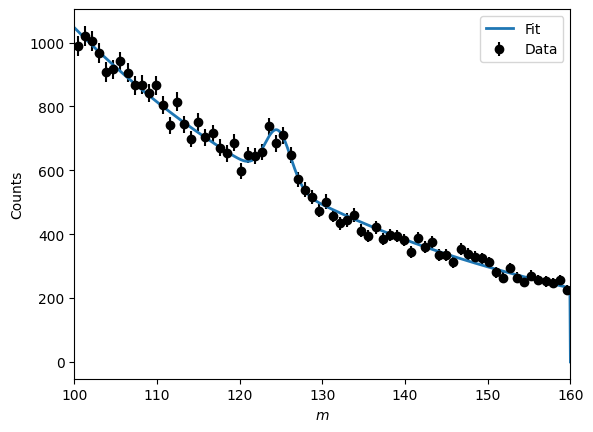

In [27]:
x_fit = np.linspace(*signal_window, 1000)
y_fit = pdf(x_fit, *m.values)

norm = np.sum(counts) * bin_width

_, ax = plt.subplots()
ax.errorbar(centers, counts, np.sqrt(counts), fmt="ok", label="Data")
ax.plot(x_fit, y_fit*norm, label="Fit", lw=2)
ax.set_xlabel("$m$")
ax.set_ylabel("Counts")
ax.set_xlim(signal_window)
plt.legend();

A thing that is often interesting to see, are the so called "pulls".
This is 

$$
\mathrm{Pull} = \frac{\mathrm{Observed} - \mathrm{Expected}}{\mathrm{Uncertainty}}
$$

Let's check it out.

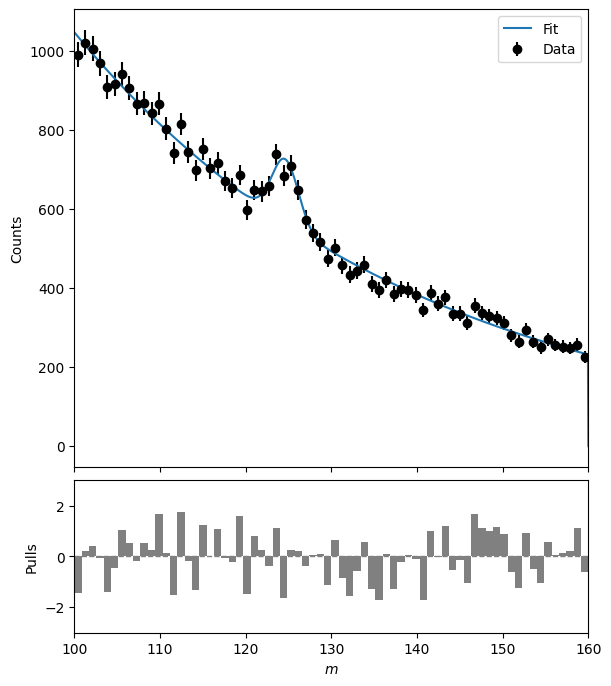

In [28]:
y_expected = pdf(centers, *m.values) * norm
pulls = (counts - y_expected) / np.sqrt(counts)
pulls[np.isnan(pulls)] = 0  # Avoid NaN issues when counts=0

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True, figsize=(6,1.5* 4.5), constrained_layout=True)

# Upper plot: Histogram with fit
ax[0].errorbar(centers, counts, yerr=np.sqrt(counts), fmt="ok", label="Data")
ax[0].plot(x_fit, y_fit * norm, label="Fit")
ax[0].set_ylabel("Counts")
ax[0].set_xlim(signal_window)
ax[0].legend()

# Lower plot: Pulls
ax[1].axhline(0, color='grey', linestyle='--', lw=1)
ax[1].stairs(pulls, bins, color="grey", fill=True)
ax[1].set_xlabel("$m$")
ax[1].set_ylabel("Pulls")
ax[1].set_xlim(signal_window)
ax[1].set_ylim(-3, 3);

Great we can perform now unbinned negative log-likelihood fits.
This is very nice.

### Exercise: Let's do a Binned Maximum-Likelihood Fit

We start with our data same as before.

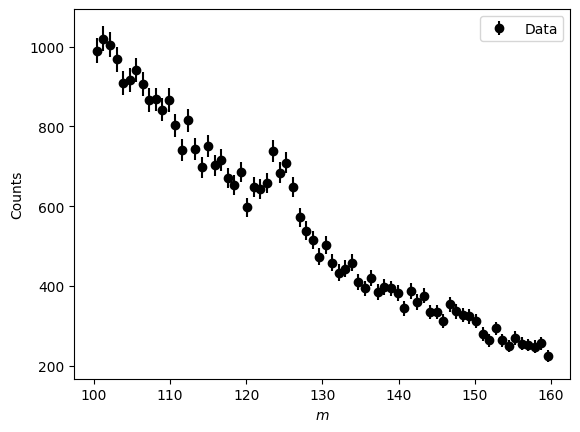

In [29]:
counts, bins = np.histogram(data, bins=70)
centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]

_, ax = plt.subplots()
ax.errorbar(centers, counts, np.sqrt(counts), fmt="ok", label="Data")
ax.set_xlabel("$m$")
ax.set_ylabel("Counts")
plt.legend();

Here we need the commulative distribution functions of our signal and background distributions.  
Please checkout the iminuit tutorial for [iminuit.cost.ExtendedBinnedNLL](https://scikit-hep.org/iminuit/notebooks/cost_functions.html#Extended-binned-maximum-likelihood-fit).  
Adjust the `pdf` function from above and adjust also the other code to make the fit work.

In [30]:
def integral(counts, s, b, mu, sigma, tau):
    return s * truncnorm.cdf(counts, *signal_window, mu, sigma) + b * truncexpon.cdf(counts, *signal_window, 0, tau)
    
cost_function = cost.ExtendedBinnedNLL(counts, bins, integral)

m = Minuit(cost_function, s=len(signal), b=len(background), mu=120, sigma=1, tau=40)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 59.91 (χ²/ndof = 0.9)      │              Nfcn = 152              │
│ EDM = 3.69e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │    740    │    90     │            │            │         │         │       │
│ 1 │ b     │  37.82e3  │  0.21e3   │            │            │         │         │       │
│ 2 │ mu    │  124.56   │   0.21    │            │            │         │         │       │
│ 3 │ sigma │   1.61    │   0.20    │            │            │         │         │       │
│ 4 │ tau   │   39.8    │    0.5    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────────────────────────────────────────┐
│       │        s        b       mu    sigma      tau │
├───────┼──────────────────────────────────────────────┤
│     s │ 7.28e+03     -7e3    -1.19     9.31    -1.73 │
│     b │     -7e3 4.44e+04     1.19    -9.31     1.73 │
│    mu │    -1.19     1.19   0.0431    -0.00    -0.00 │
│ sigma │     9.31    -9.31    -0.00   0.0402    -0.00 │
│   tau │    -1.73     1.73    -0.00    -0.00    0.248 │
└───────┴──────────────────────────────────────────────┘

Try to plot also the results of your fit with matplotlib similar to the way we did before.  
For Binned fits it is nice to underline it by also showing the fit result in a binned way.  
For this the `np.diff()` function and the `plt.stairs()` function can be useful.

In [31]:
# Calculate expected counts per bin (difference of cumulative at bin edges)
y_fit_cumulative = integral(bins, *m.values)
y_fit = np.diff(y_fit_cumulative)

pulls = (counts - y_fit) / np.sqrt(counts)
pulls[np.isnan(pulls)] = 0

# Plotting
fig, ax = plt.subplots(
    2, 1, gridspec_kw={'height_ratios': [3, 1]},
    sharex=True, figsize=(6, 1.5 * 4.5), constrained_layout=True
)

# Upper plot: Data and fit
ax[0].errorbar(centers, counts, yerr=np.sqrt(counts), fmt="ok", label="Data")
ax[0].stairs(y_fit, bins, label="Fit", lw=2)
ax[0].set_ylabel("Counts")
ax[0].set_xlim(signal_window)
ax[0].legend()

# Lower plot: Pulls
ax[1].axhline(0, color='grey', linestyle='--', lw=1)
ax[1].stairs(pulls, bins, color="grey", fill=True)
ax[1].set_xlabel("$m$")
ax[1].set_ylabel("Pulls")
ax[1].set_xlim(signal_window)
ax[1].set_ylim(-3, 3);